# **Tutorial 5: Xarray Data Analysis and Climatology**

**Week 1, Day 1, Introduction to the Climate System**

**Content creators:** Sloane Garelick, Julia Kent

**Content reviewers:** Danika Gupta, Younkap Nina Duplex 

**Content editors:** Agustina Pesce

**Production editors:** TBD

**Our 2023 Sponsors:** TBD


###**Code and Data Sources**

Code and data for this tutorial is based on existing content from [Project Pythia](https://foundations.projectpythia.org/core/xarray/computation-masking.html).

## **Tutorial 5 Objectives**

Global climate can vary on long timescales, but it's also important to understand seasonal variations. For example, seasonal variations in precipitation associated with the migration of the ITCZ and monsoon systems occur in response to seasonal changes in temperature. In this tutorial, we will use data analysis tools in Xarray to explore seasonal climatology in global temperature and precipitation data. 

## Imports


In [1]:
!pip install matplotlib.pyplot
!pip install numpy
!pip install xarray
!pip install pythia_datasets
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pythia_datasets import DATASETS
import pandas as pd

Let's load the same data that we used in the previous tutorial (monthly SST data from CESM2):

In [16]:
filepath = DATASETS.fetch('CESM2_sst_data.nc')
ds = xr.open_dataset(filepath,decode_times=False)
new_time = pd.date_range(start='2000-01-15', end='2014-12-15', periods=180)
ds = ds.assign(time=new_time)

## GroupBy: Split, Apply, Combine

Simple aggregations can give useful summary of our dataset, but often we would prefer to aggregate conditionally on some coordinate labels or groups. Xarray provides the so-called `groupby` operation which enables the **split-apply-combine** workflow on xarray DataArrays and Datasets. The split-apply-combine operation is illustrated in this figure


This makes clear what the `groupby` accomplishes:

- The split step involves breaking up and grouping an xarray Dataset or DataArray depending on the value of the specified group key.
- The apply step involves computing some function, usually an aggregate, transformation, or filtering, within the individual groups.
- The combine step merges the results of these operations into an output xarray Dataset or DataArray.

We are going to use `groupby` to remove the seasonal cycle ("climatology") from our dataset. See the [xarray `groupby` user guide](https://xarray.pydata.org/en/stable/user-guide/groupby.html) for more examples of what `groupby` can take as an input.

First, let's select a gridpoint closest to a specified lat-lon, and plot a time series of SST at that point. The annual cycle will be quite evident.

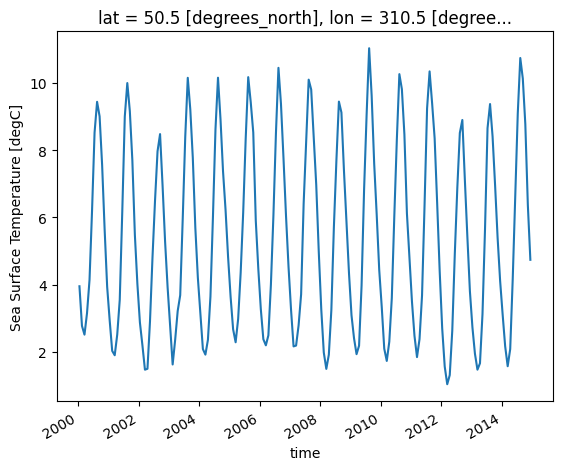

In [17]:
ds.tos.sel(lon=310, lat=50, method='nearest').plot(); #time range is 2000 to 2013

### Split

Let's group data by month, i.e. all Januaries in one group, all Februaries in one group, etc.


In [7]:
ds.tos.groupby(ds.time.dt.month)

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

<div class="admonition alert alert-info">

In the above code, we are using the `.dt` [`DatetimeAccessor`](https://xarray.pydata.org/en/stable/generated/xarray.core.accessor_dt.DatetimeAccessor.html) to extract specific components of dates/times in our time coordinate dimension. For example, we can extract the year with `ds.time.dt.year`. See also the equivalent [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html).
    
   </div>

Xarray also offers a more concise syntax when the variable you’re grouping on is already present in the dataset. This is identical to `ds.tos.groupby(ds.time.dt.month)`:

In [8]:
ds.tos.groupby('time.month')

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

### Apply & Combine 

Now that we have groups defined, it’s time to “apply” a calculation to the group. These calculations can either be:

- aggregation: reduces the size of the group
- transformation: preserves the group’s full size

At then end of the apply step, xarray will automatically combine the aggregated/transformed groups back into a single object. 



#### Compute climatology 


Let's calculate the climatology at every point in the dataset:


In [9]:
tos_clim = ds.tos.groupby('time.month').mean()
tos_clim

<xarray.DataArray 'tos' (month: 12, lat: 180, lon: 360)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.780786 , -1.780688 , -1.7805718, ..., -1.7809757,
         -1.7809197, -1.7808627],
        [-1.7745041, -1.7744204, -1.7743237, ..., -1.77467  ,
         -1.774626 , -1.7745715],
        [-1.7691481, -1.7690798, -1.7690051, ..., -1.7693441,
         -1.7692844, -1.7692182]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [-1.7605033, -1.760397 , -1.7602725, ..., -1.760718 ,
         -1.7606541, -1.7605885],
        [-1.7544289, -1.7543424, -1.7542422, ..., -1.754608 ,
         -1.754559 , -1.7545002],
        [-1.7492163, -1.749148 , -1.7490736, ..., -1.7494118,
         -1.7493519, -1.7492864]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.7711828, -1.7710832, -1.7709653, ..., -1.7713748,
         -1.7713183, -1.7712607],
        [-1.7648666, -1.7647841, -1.7646879, ..., -1.7650299,
         -1.7649865, -1.7649331],
        [-1.759478 , -1.7594113, -1.7593384, ..., -1.7596704,
         -1.7596117, -1.759547 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    This may differ from "surface temperature" in regions of ...
    frequency:      mon
    id:             tos
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Surface Temperature
    type:           real
    units:          degC
    variable_id:    tos

Plot climatology at a specific point:

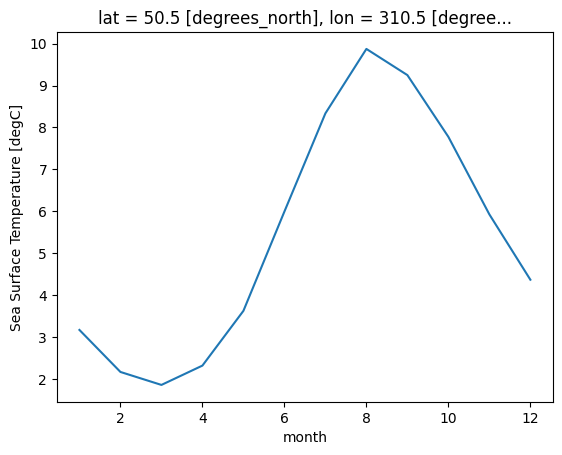

In [10]:
tos_clim.sel(lon=310, lat=50, method='nearest').plot();

Plot zonal mean climatology:

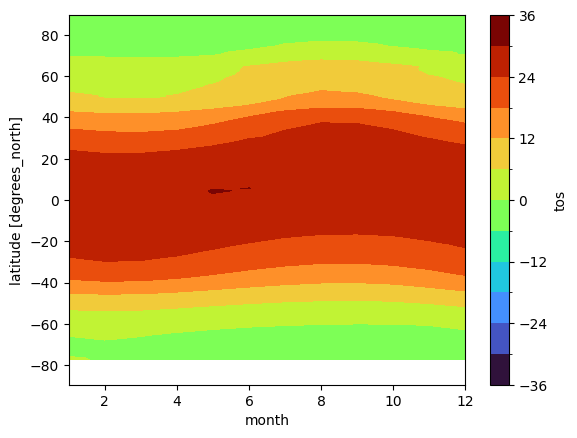

In [11]:
tos_clim.mean(dim='lon').transpose().plot.contourf(levels=12, cmap='turbo');

Calculate and plot the difference between January and December climatologies:

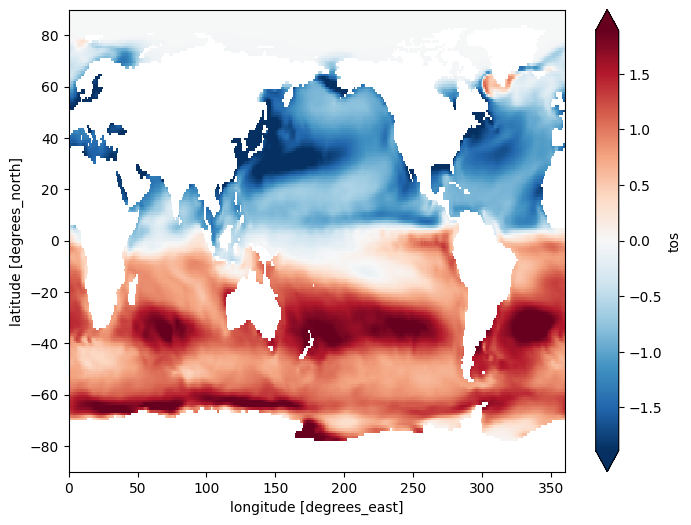

In [12]:
(tos_clim.sel(month=1) - tos_clim.sel(month=12)).plot(size=6, robust=True);

#**Climate Connection**

The plot you just created shows seasonal variations in SST over one year at 50ºN and 130ºE. How do you think seasonal variations in SST would differ at the equator? What about at the poles? What about at 50ºS?




